In [28]:
from pprint import pprint

from os.path import join

from pymagicc.io import MAGICCData

%matplotlib inline

In [29]:
DATA_DIR = join("..", "tests", "test_data")

In [30]:
rcp = MAGICCData()
rcp.read(join(DATA_DIR, "RCP3PD_EMISSIONS.DAT"))

In [31]:
rcp.df.head()

,variable,todo,unit,region,time,value
0,Emissions|CO2|MAGICC Fossil and Industrial,N/A,Gt C / yr,World,1765,0.003
1,Emissions|CO2|MAGICC Fossil and Industrial,N/A,Gt C / yr,World,1766,0.003
2,Emissions|CO2|MAGICC Fossil and Industrial,N/A,Gt C / yr,World,1767,0.003
3,Emissions|CO2|MAGICC Fossil and Industrial,N/A,Gt C / yr,World,1768,0.003
4,Emissions|CO2|MAGICC Fossil and Industrial,N/A,Gt C / yr,World,1769,0.003


In [32]:
pprint(list(rcp.df["variable"].unique()))

['Emissions|CO2|MAGICC Fossil and Industrial',
 'Emissions|CO2|MAGICC AFOLU',
 'Emissions|CH4',
 'Emissions|N2O',
 'Emissions|SOx',
 'Emissions|CO',
 'Emissions|NMVOC',
 'Emissions|NOx',
 'Emissions|BC',
 'Emissions|OC',
 'Emissions|NH3',
 'Emissions|CF4',
 'Emissions|C2F6',
 'Emissions|C6F14',
 'Emissions|HFC23',
 'Emissions|HFC32',
 'Emissions|HFC4310',
 'Emissions|HFC125',
 'Emissions|HFC134a',
 'Emissions|HFC143a',
 'Emissions|HFC227ea',
 'Emissions|HFC245fa',
 'Emissions|SF6',
 'Emissions|CFC11',
 'Emissions|CFC12',
 'Emissions|CFC113',
 'Emissions|CFC114',
 'Emissions|CFC115',
 'Emissions|CCl4',
 'Emissions|CH3CCl3',
 'Emissions|HCFC22',
 'Emissions|HCFC141b',
 'Emissions|HCFC142b',
 'Emissions|Halon1211',
 'Emissions|Halon1202',
 'Emissions|Halon1301',
 'Emissions|Halon2402',
 'Emissions|CH3Br',
 'Emissions|CH3Cl']


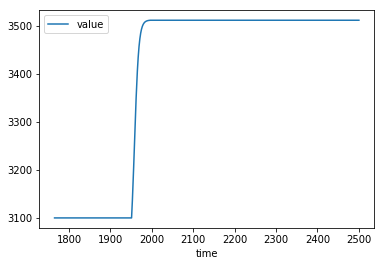

In [35]:
rcp.df[
    rcp.df["variable"] == "Emissions|CH3Cl"
].plot(x="time", y="value");